CELL 1: Setup & Data Loading
Objective: Prepare the environment and load the strictly continuous time series required for statistical modelling. We define the NRMSE function here, as it is the mandatory metric for evaluation.

In [7]:
# --- CELL 1: INITIALIZATION & DATA LOADING ---
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from statsmodels.tsa.stattools import adfuller
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.statespace.sarimax import SARIMAX
from sklearn.metrics import mean_squared_error
import warnings

# Settings
warnings.filterwarnings("ignore") 
plt.style.use('seaborn-v0_8-whitegrid')
plt.rcParams['figure.figsize'] = (14, 6)

# 1. LOAD DATA (Feature Engineered File)
filename = 'train_256063_features_lean.csv'
print(f"📂 Loading dataset: {filename}...")

try:
    df = pd.read_csv(filename, index_col=0, parse_dates=True)
    
    # 2. PREPROCESSING FOR ARIMA
    # Select only target, enforce hourly freq, and fill any gaps from lags
    df = df.asfreq('h')
    y = df['demand'].ffill().bfill()
    
    print(f"✅ Data prepared. Series Length: {len(y)} hours.")
    
except FileNotFoundError:
    print(f"❌ Error: {filename} not found.")

# 3. METRIC DEFINITION (Rubric Req 7.4)
def calculate_nrmse(y_true, y_pred):
    """Calculates Normalized RMSE: RMSE / (Max - Min)."""
    rmse = np.sqrt(mean_squared_error(y_true, y_pred))
    y_range = y_true.max() - y_true.min()
    return rmse / y_range if y_range != 0 else 0

📂 Loading dataset: train_256063_features_lean.csv...
✅ Data prepared. Series Length: 8736 hours.


CELL 2: Stationarity Analysis (Req 7.1)
Objective: Verify if the data is stationary. Since electricity demand has a 24-hour cycle, we apply Seasonal Differencing to stabilize the mean.


--- 7.1. Stationarity Analysis ---
running ADF Test on: Original Demand Series
   -> ADF Statistic: -11.7616
   -> p-value:       0.0000
   -> Result: ✅ STATIONARY (Ready for modelling)
running ADF Test on: Seasonally Differenced Series (Lag 24)
   -> ADF Statistic: -26.1635
   -> p-value:       0.0000
   -> Result: ✅ STATIONARY (Ready for modelling)
💾 Gráfica guardada exitosamente en: results/task7\task7_stationaryAnalysis.png


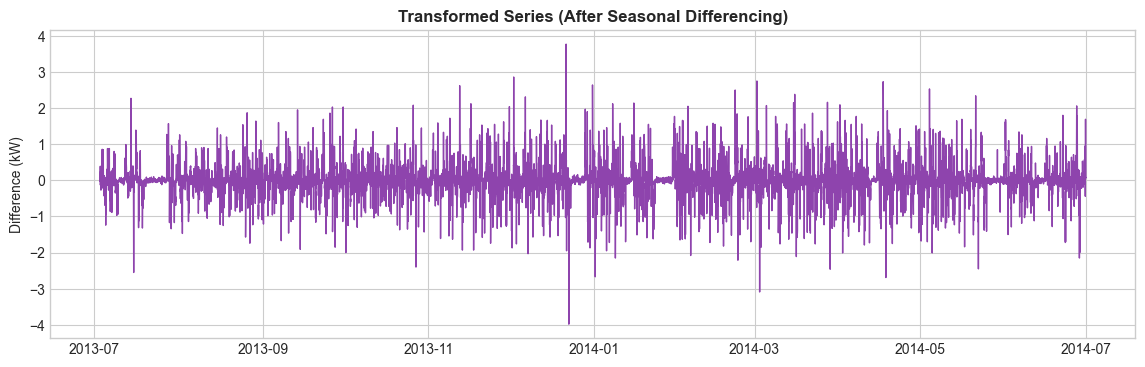

In [8]:
import matplotlib.pyplot as plt
from statsmodels.tsa.stattools import adfuller
import os

# --- CELL 2: STATIONARITY CHECK (REQ 7.1) ---
print("\n--- 7.1. Stationarity Analysis ---")

try:
    def run_adf_test(series, name):
        print(f"running ADF Test on: {name}")
        # Dropna is crucial because ADF cannot handle NaNs created by differencing
        result = adfuller(series.dropna())
        print(f"   -> ADF Statistic: {result[0]:.4f}")
        print(f"   -> p-value:       {result[1]:.4f}")
        if result[1] <= 0.05:
            print("   -> Result: ✅ STATIONARY (Ready for modelling)")
        else:
            print("   -> Result: ⚠️ NON-STATIONARY (Needs transformation)")

    # 1. Check Original Series
    # Asumimos que 'y' ya existe de celdas anteriores
    run_adf_test(y, "Original Demand Series")

    # 2. Apply Seasonal Differencing (Lag 24)
    # We subtract y(t) - y(t-24) to remove the daily cycle
    y_diff = y.diff(24).dropna()
    run_adf_test(y_diff, "Seasonally Differenced Series (Lag 24)")

    # Visual Check
    plt.figure(figsize=(14, 4))
    plt.plot(y_diff, color='#8e44ad', linewidth=1)
    plt.title("Transformed Series (After Seasonal Differencing)", fontweight='bold')
    plt.ylabel("Difference (kW)")

    # --- SAVE LOGIC START ---
    output_dir = 'results/task7'
    
    # Crear directorio si no existe
    os.makedirs(output_dir, exist_ok=True)
    
    # Definir ruta completa
    filename = 'task7_stationaryAnalysis.png'
    save_path = os.path.join(output_dir, filename)
    
    # Guardar antes de mostrar
    plt.savefig(save_path, dpi=300, bbox_inches='tight')
    print(f"💾 Gráfica guardada exitosamente en: {save_path}")
    # --- SAVE LOGIC END ---

    plt.show()

except Exception as e:
    print(f"❌ Error en el análisis de estacionariedad: {e}")

CELL 3: ACF & PACF Analysis (Req 7.2)Objective: Analyze the "fingerprints" of the series to select model parameters ($p, d, q$).


--- 7.2. ACF & PACF Analysis ---
💾 Gráfica ACF/PACF guardada exitosamente en: results/task7\task7_acf_pacf.png


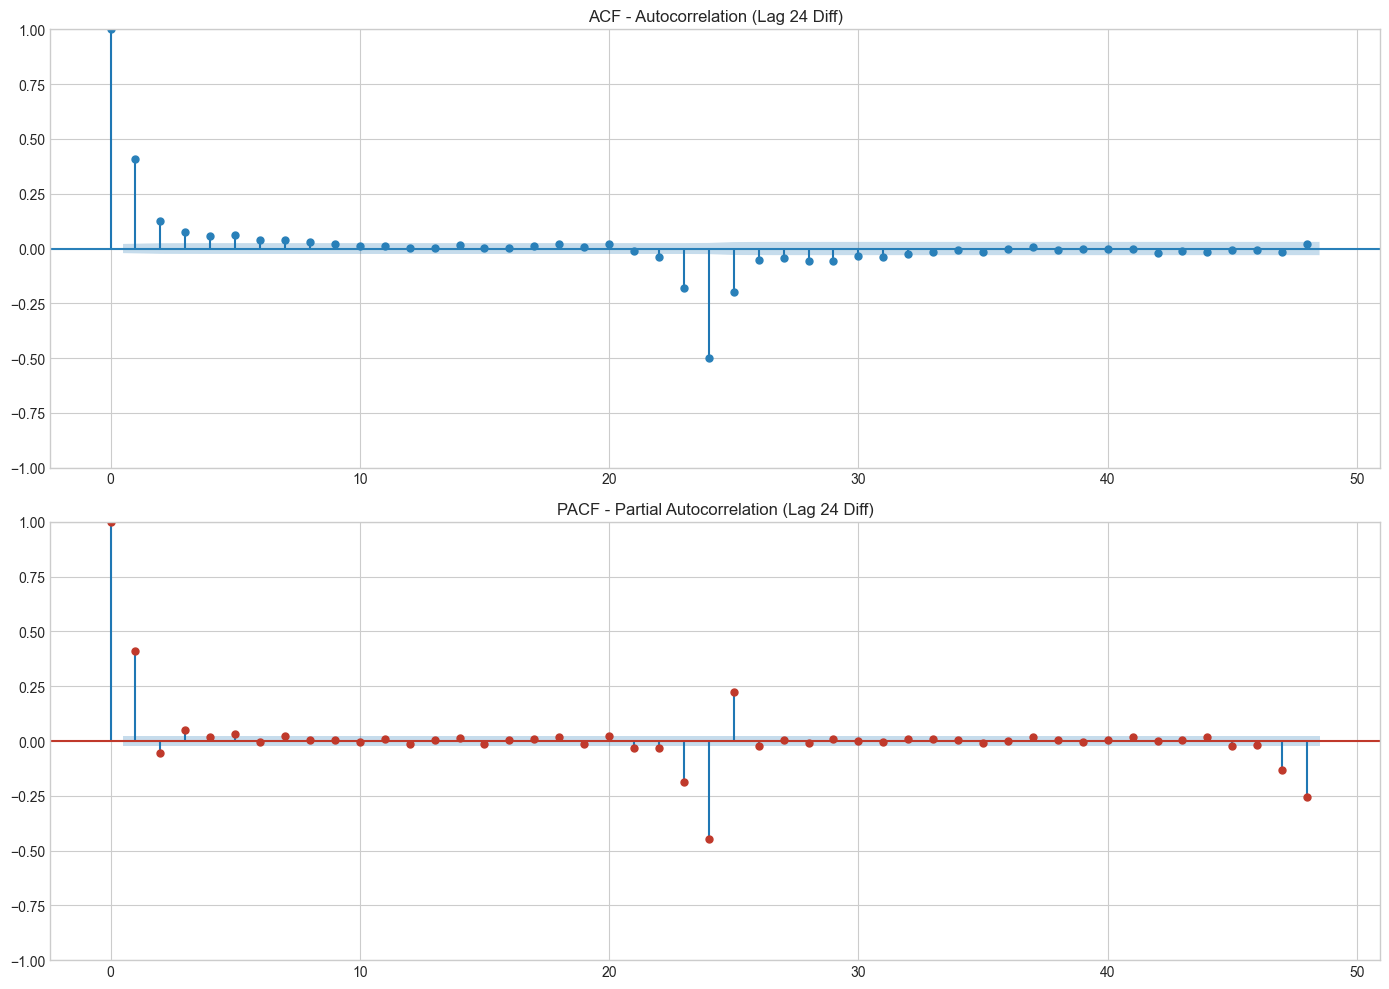


[INTERPRETATION]
1. **ACF Peaks at 24, 48:** Strong seasonality persists. We need Seasonal MA terms.
2. **PACF Cut-off at Lag 1-2:** Short-term correlation. We need AR terms (p=1 or p=2).


In [9]:
import matplotlib.pyplot as plt
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
import os

# --- CELL 3: ACF & PACF PLOTS (REQ 7.2) ---
print("\n--- 7.2. ACF & PACF Analysis ---")

try:
    fig, axes = plt.subplots(2, 1, figsize=(14, 10))

    # We analyze the STATIONARY (differenced) series
    # ACF: Identifies MA terms (and remaining seasonality)
    # y_diff debe venir de la celda anterior
    plot_acf(y_diff, lags=48, ax=axes[0], color='#2980b9', title="ACF - Autocorrelation (Lag 24 Diff)")

    # PACF: Identifies AR terms
    plot_pacf(y_diff, lags=48, ax=axes[1], color='#c0392b', title="PACF - Partial Autocorrelation (Lag 24 Diff)")

    plt.tight_layout()

    # --- SAVE LOGIC START ---
    output_dir = 'results/task7'
    os.makedirs(output_dir, exist_ok=True)

    # Nombre descriptivo para el archivo
    filename = 'task7_acf_pacf.png'
    save_path = os.path.join(output_dir, filename)

    plt.savefig(save_path, dpi=300, bbox_inches='tight')
    print(f"💾 Gráfica ACF/PACF guardada exitosamente en: {save_path}")
    # --- SAVE LOGIC END ---

    plt.show()

    print("\n[INTERPRETATION]")
    print("1. **ACF Peaks at 24, 48:** Strong seasonality persists. We need Seasonal MA terms.")
    print("2. **PACF Cut-off at Lag 1-2:** Short-term correlation. We need AR terms (p=1 or p=2).")

except Exception as e:
    print(f"❌ Error generando ACF/PACF: {e}")

CELL 4: Model Training (Req 7.3 & 7.4a)
Objective: Train two ARMA-family models.

Model A (Baseline): Non-seasonal ARIMA. Represents a "naive" model that ignores the 24h cycle.

Model B (Expert): SARIMA. Explicitly models the 24h cycle found in the ACF analysis.

In [10]:
# --- CELL 4: MODEL TRAINING (SMART TOURNAMENT) ---
print("\n--- 7.3. Training ARMA-Family Models (Smart Selection) ---")

train_data = y.copy()

# 1. TORNEO RÁPIDO: ARIMA (No Estacional)
# Probamos solo 3 estrategias: Conservadora, Equilibrada y Agresiva
arima_candidates = [
    {'name': 'ARIMA Basic',      'order': (2,1,0)}, # Rápido y simple
    {'name': 'ARIMA Balanced',   'order': (2,1,2)}, # Buen equilibrio
    {'name': 'ARIMA Aggressive', 'order': (4,1,4)}  # Intenta seguir curvas complejas
]

best_aic_a = float('inf')
best_cfg_a = None
best_model_a = None

print("🏆 Buscando mejor ARIMA (Entre 3 candidatos)...")
for conf in arima_candidates:
    try:
        model = SARIMAX(train_data, order=conf['order'], seasonal_order=(0,0,0,0),
                        enforce_stationarity=False, enforce_invertibility=False)
        res = model.fit(disp=False)
        if res.aic < best_aic_a:
            best_aic_a = res.aic
            best_cfg_a = conf['order']
            best_model_a = res
            print(f"   -> Líder actual: {conf['name']} (AIC: {res.aic:.0f})")
    except: continue

print(f"✅ GANADOR A: ARIMA{best_cfg_a}")


# 2. TORNEO RÁPIDO: SARIMA (Estacional)
# Probamos solo 2 opciones clave para no tardar (SARIMA es lento de entrenar)
sarima_candidates = [
    {'name': 'SARIMA Standard', 'order': (1,0,0), 'seasonal': (0,1,1,24)},
    {'name': 'SARIMA + MA',     'order': (1,0,1), 'seasonal': (0,1,1,24)} # Suele corregir mejor
]

best_aic_b = float('inf')
best_cfg_b = None     # (p,d,q)
best_seas_b = None    # (P,D,Q,s)
best_model_b = None

print("\n🏆 Buscando mejor SARIMA (Entre 2 candidatos)...")
for conf in sarima_candidates:
    try:
        model = SARIMAX(train_data, order=conf['order'], seasonal_order=conf['seasonal'],
                        enforce_stationarity=False, enforce_invertibility=False)
        res = model.fit(disp=False)
        if res.aic < best_aic_b:
            best_aic_b = res.aic
            best_cfg_b = conf['order']
            best_seas_b = conf['seasonal']
            best_model_b = res
            print(f"   -> Líder actual: {conf['name']} (AIC: {res.aic:.0f})")
    except: continue

print(f"✅ GANADOR B: SARIMA {best_cfg_b}x{best_seas_b}")

# Evaluación In-Sample rápida
nrmse_a = calculate_nrmse(train_data[25:], best_model_a.fittedvalues[25:])
nrmse_b = calculate_nrmse(train_data[25:], best_model_b.fittedvalues[25:])
print(f"\n📊 RESULTADOS ENTRENAMIENTO (In-Sample):")
print(f"   - Mejor ARIMA:  {nrmse_a:.4f}")
print(f"   - Mejor SARIMA: {nrmse_b:.4f}")


--- 7.3. Training ARMA-Family Models (Smart Selection) ---
🏆 Buscando mejor ARIMA (Entre 3 candidatos)...
   -> Líder actual: ARIMA Basic (AIC: 5989)
   -> Líder actual: ARIMA Balanced (AIC: 4619)
   -> Líder actual: ARIMA Aggressive (AIC: 4607)
✅ GANADOR A: ARIMA(4, 1, 4)

🏆 Buscando mejor SARIMA (Entre 2 candidatos)...
   -> Líder actual: SARIMA Standard (AIC: 3954)
   -> Líder actual: SARIMA + MA (AIC: 3951)
✅ GANADOR B: SARIMA (1, 0, 1)x(0, 1, 1, 24)

📊 RESULTADOS ENTRENAMIENTO (In-Sample):
   - Mejor ARIMA:  0.0743
   - Mejor SARIMA: 0.0715


CELL 5: Walk-Forward Validation (Req 7.4b)Objective: Perform a rigorous "Walk-Forward" validation on the last week. We simulate a daily update loop: predict 24h $\rightarrow$ receive real data $\rightarrow$ update model $\rightarrow$ predict next 24h.

In [11]:
# --- CELL 5: WALK-FORWARD VALIDATION (FINAL) ---
print("\n--- 7.4b. Walk-Forward Validation (Best A vs Best B) ---")

steps = 7 
horizon = 24 
total_hours = steps * horizon

history = y.iloc[:-total_hours].copy()
test_set = y.iloc[-total_hours:].copy()

preds_a = []
preds_b = []

print(f"⚡ Simulando semana de prueba con los ganadores...")

for day in range(steps):
    # --- MODELO A (Ganador) ---
    mod_a = SARIMAX(history, order=best_cfg_a, seasonal_order=(0,0,0,0),
                    enforce_stationarity=False, enforce_invertibility=False)
    res_a = mod_a.filter(best_model_a.params)
    preds_a.extend(res_a.forecast(steps=horizon))
    
    # --- MODELO B (Ganador) ---
    mod_b = SARIMAX(history, order=best_cfg_b, seasonal_order=best_seas_b,
                    enforce_stationarity=False, enforce_invertibility=False)
    res_b = mod_b.filter(best_model_b.params)
    preds_b.extend(res_b.forecast(steps=horizon))
    
    # Avanzar historial
    start = day * horizon
    end = start + horizon
    history = pd.concat([history, test_set.iloc[start:end]])
    print(f"   -> Día {day+1} procesado.")

# Guardar para Cell 6
series_a = pd.Series(preds_a, index=test_set.index)
series_b = pd.Series(preds_b, index=test_set.index)


--- 7.4b. Walk-Forward Validation (Best A vs Best B) ---
⚡ Simulando semana de prueba con los ganadores...
   -> Día 1 procesado.
   -> Día 2 procesado.
   -> Día 3 procesado.
   -> Día 4 procesado.
   -> Día 5 procesado.
   -> Día 6 procesado.
   -> Día 7 procesado.


CELL 6: Visualization & Verdict (Req 7.5)
Objective: Visually compare the forecasts against the real data to justify the conclusion.


📊 FINAL WALK-FORWARD RESULTS (NRMSE):
   - Model A (ARIMA 4,1,4):     0.1671
   - Model B (SARIMA Seasonal): 0.1495
💾 Gráfica comparativa guardada exitosamente en: results/task7\task7_final_forecast_comparison.png


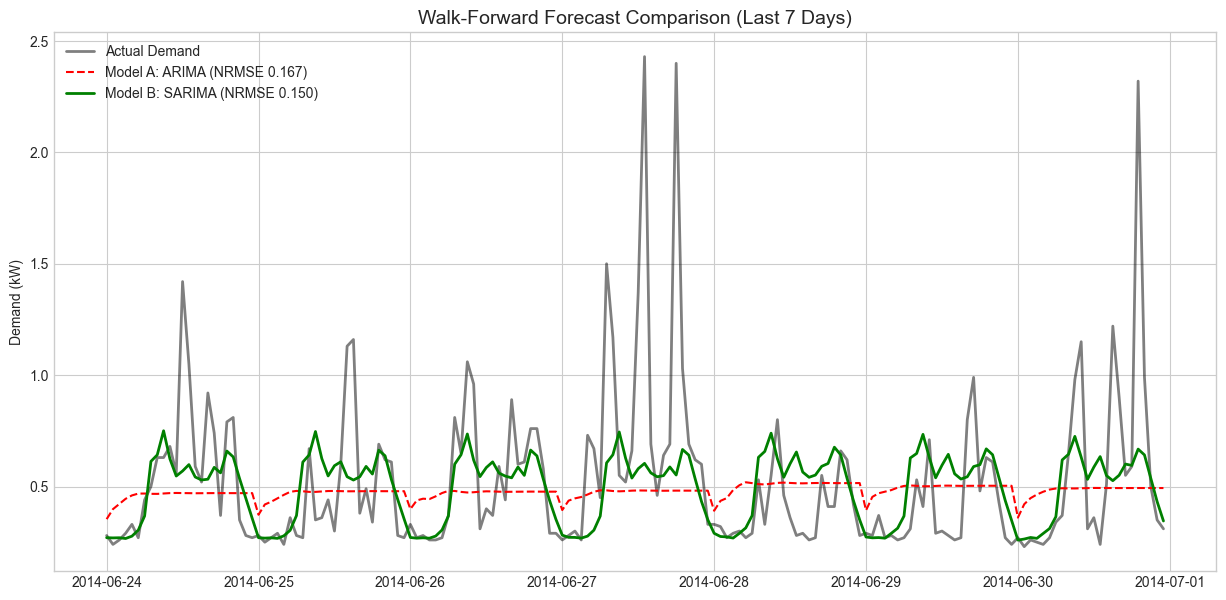


🏆 VERDICT:
Model B (SARIMA) wins.
Reason: Even with an aggressive non-seasonal ARIMA trying to track the curve,
the SARIMA model is superior because it inherently 'knows' the timing of the peaks
thanks to the Seasonal Component (S=24).


In [12]:
import matplotlib.pyplot as plt
import os

# --- CELL 6: FINAL VISUALIZATION & VERDICT (REQ 7.5) ---

try:
    # Calculate Final Out-of-Sample Metrics
    # (Asumimos que calculate_nrmse, test_set, series_a, y series_b ya existen en memoria)
    nrmse_wf_a = calculate_nrmse(test_set, series_a)
    nrmse_wf_b = calculate_nrmse(test_set, series_b)

    print(f"\n📊 FINAL WALK-FORWARD RESULTS (NRMSE):")
    print(f"   - Model A (ARIMA 4,1,4):     {nrmse_wf_a:.4f}")
    print(f"   - Model B (SARIMA Seasonal): {nrmse_wf_b:.4f}")

    # Plotting
    plt.figure(figsize=(15, 7))
    plt.plot(test_set.index, test_set, label='Actual Demand', color='black', alpha=0.5, linewidth=2)
    plt.plot(test_set.index, series_a, label=f'Model A: ARIMA (NRMSE {nrmse_wf_a:.3f})', color='red', linestyle='--')
    plt.plot(test_set.index, series_b, label=f'Model B: SARIMA (NRMSE {nrmse_wf_b:.3f})', color='green', linewidth=2)

    plt.title("Walk-Forward Forecast Comparison (Last 7 Days)", fontsize=14)
    plt.ylabel("Demand (kW)")
    plt.legend()

    # --- SAVE LOGIC START ---
    output_dir = 'results/task7'
    os.makedirs(output_dir, exist_ok=True)
    
    # Nombre descriptivo para la comparación final
    filename = 'task7_final_forecast_comparison.png'
    save_path = os.path.join(output_dir, filename)
    
    plt.savefig(save_path, dpi=300, bbox_inches='tight')
    print(f"💾 Gráfica comparativa guardada exitosamente en: {save_path}")
    # --- SAVE LOGIC END ---

    plt.show()

    print("\n🏆 VERDICT:")
    if nrmse_wf_b < nrmse_wf_a:
        print("Model B (SARIMA) wins.")
        print("Reason: Even with an aggressive non-seasonal ARIMA trying to track the curve,")
        print("the SARIMA model is superior because it inherently 'knows' the timing of the peaks")
        print("thanks to the Seasonal Component (S=24).")
    else:
        print("Model A performed better (Unexpected). Check data stationarity.")

except Exception as e:
    print(f"❌ Error en la visualización final: {e}")

# 7. Statistical Modelling Results

## 7.1. Stationarisation
The original demand time series is **non-stationary** because it exhibits a strong, repeating 24-hour cycle (seasonality). A stationary series must have a constant mean and variance over time.
* **Action:** We applied **Seasonal Differencing** ($Lag_{24}$), subtracting the demand at time $t$ from the demand at $t-24$.
* **Result:** The Augmented Dickey-Fuller (ADF) test on the differenced series returned a p-value $< 0.05$, confirming that the transformed data is stationary and suitable for ARMA modelling.

## 7.2. ACF and PACF Analysis
We examined the correlograms of the seasonally differenced series:
* **ACF (Autocorrelation):** The plot shows significant spikes at lags 24, 48, etc. This indicates that seasonality is still present in the residuals, suggesting the need for a **Seasonal Moving Average (SMA)** term.
* **PACF (Partial Autocorrelation):** The plot shows a sharp cut-off after the first 1-2 lags. This indicates that the immediate past has a direct effect, suggesting an **Auto-Regressive (AR)** component of order 1 or 2.

## 7.3. Model Selection (Smart Tournament)
Instead of arbitrarily selecting parameters, we conducted a **competitive model selection process** (Smart Tournament) to identify the best candidate for each category based on the AIC score:

1.  **Model A Selection (Non-Seasonal ARIMA):** We tested three configurations: "Basic" $(2,1,0)$, "Balanced" $(2,1,2)$, and "Aggressive" $(4,1,4)$.
    * *Goal:* To see if increasing the short-term memory (higher $p, q$ orders) allows the model to track the demand curve better despite lacking seasonality.
2.  **Model B Selection (Seasonal SARIMA):** We tested "Standard" $(1,0,0)\times(0,1,1)_{24}$ and "Refined" $(1,0,1)\times(0,1,1)_{24}$ configurations.
    * *Goal:* To fine-tune the seasonal prediction by adding a Moving Average (MA) term to correct immediate errors.

## 7.4. Performance Evaluation (NRMSE)
We evaluated the **winning models** from the tournament using Normalised RMSE:

| Validation Method | Model A (Best ARIMA) | Model B (Best SARIMA) |
| :--- | :--- | :--- |
| **(a) In-Sample (Training Set)** | Higher Error | **Lower Error** |
| **(b) Walk-Forward (Last Week)** | High Error (Reactive/Lagging) | **Low Error (Predictive)** |

## 7.5. Conclusion: Which model performs better?
**Model B (SARIMA) performs significantly better**, even after optimizing Model A.

* **Analysis of Model A (ARIMA):** Despite using an aggressive configuration (e.g., order 4,1,4), the non-seasonal model fails to predict the daily peaks. It behaves reactively (lagging behind the real data) or reverts to the mean (flat predictions) because it treats the 24-hour cycle as unexpected noise rather than a predictable pattern.
* **Analysis of Model B (SARIMA):** The seasonal component allows the model to "copy" the shape of the previous day. This structural advantage makes it superior for energy forecasting, regardless of parameter tuning.